In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [25]:
class Data:
    def __init__(self):
        self.dataframe = pd.DataFrame([])

    def read(self, file_name: str):
        try:
            self.dataframe = pd.read_csv(file_name)
        except FileNotFoundError:
            print(f"File {file_name} not found.")
        except pd.errors.EmptyDataError:
            print("No data found in the file.")
        except Exception as e:
            print(f"An error occurred: {e}")

    def clean_data(self):
        """Remove null values"""
        self.dataframe = self.dataframe.dropna()

    def print_head(self):
        """Print the first few rows of the dataframe"""
        print(self.dataframe.head())
        return self.dataframe

    def print_description(self):
        """Print the statistical description of the dataframe"""
        print(self.dataframe.describe())

    def normalization(self):
        """Normalize the data frame, excluding the Date and district columns"""
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        numeric_columns = self.dataframe.select_dtypes(include=['float64', 'int64']).columns
        self.dataframe[numeric_columns] = self.scaler.fit_transform(self.dataframe[numeric_columns])

    def visualize_NORMAL(self):
        """Plot graph for Normal rainfall v/s date for all districts in a single plot"""
        if 'Dates' in self.dataframe.columns and 'NORMAL' in self.dataframe.columns and 'district' in self.dataframe.columns:
            self.dataframe['Dates'] = pd.to_datetime(self.dataframe['Dates'], format='%b-%Y')

            plt.figure(figsize=(14, 7))
            
            for district in self.dataframe['district'].unique():
                district_data = self.dataframe[self.dataframe['district'] == district]
                plt.plot(district_data['Dates'], district_data['NORMAL'], label=f'Normal Rainfall - {district}', linestyle='-')

            plt.title('Monthly Rainfall in Districts (NORMAL)')
            plt.xlabel('Date')
            plt.ylabel('Rainfall (mm)')
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.show()

        else:
            print("Column(s) not found in the dataframe")


    def visualize_ACTUAL(self):
        """Plot graph for Actual rainfall v/s date for all districts"""
        if 'Dates' in self.dataframe.columns and 'ACTUAL' in self.dataframe.columns and 'district' in self.dataframe.columns:
            self.dataframe['Dates'] = pd.to_datetime(self.dataframe['Dates'], format='%b-%Y')

            plt.figure(figsize=(14, 7))
            
            for district in self.dataframe['district'].unique():
                district_data = self.dataframe[self.dataframe['district'] == district]
                plt.plot(district_data['Dates'], district_data['ACTUAL'], label=f'Actual Rainfall - {district}', linestyle='-')

            plt.title('Monthly Rainfall in Districts (ACTUAL)')
            plt.xlabel('Date')
            plt.ylabel('Rainfall (mm)')
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.show()

        else:
            print("Column(s) not found in the dataframe")

    def prepare_lstm_data(self, seq_length=3):
        """Prepare data for LSTM model"""
        self.dataframe['Dates'] = pd.to_datetime(self.dataframe['Dates'])
        self.dataframe['Year'] = self.dataframe['Dates'].dt.year
        self.dataframe['Month'] = self.dataframe['Dates'].dt.month

        features = self.dataframe[['Year', 'Month', 'NORMAL', 'ACTUAL']]
        features_scaled = self.scaler.fit_transform(features)

        def create_sequences(data, seq_length):
            xs, ys = [], []
            for i in range(len(data) - seq_length):
                x = data[i:i + seq_length]
                y = data[i + seq_length][3]
                xs.append(x)
                ys.append(y)
            return np.array(xs), np.array(ys)

        self.X, self.y = create_sequences(features_scaled, seq_length)
        print("Shape of X:", self.X.shape)
        print("Shape of y:", self.y.shape)

    def build_lstm_model(self):
        """Build LSTM model"""
        self.model = Sequential()
        self.model.add(LSTM(50, return_sequences=True, input_shape=(self.X.shape[1], self.X.shape[2])))
        self.model.add(LSTM(50, return_sequences=False))
        self.model.add(Dense(25))
        self.model.add(Dense(1))

        self.model.compile(optimizer='adam', loss='mean_squared_error')
        self.model.summary()

    def train_lstm_model(self, epochs=50, batch_size=1):
        """Train LSTM model"""
        train_size = int(len(self.X) * 0.8)
        self.X_train, self.X_test = self.X[:train_size], self.X[train_size:]
        self.y_train, self.y_test = self.y[:train_size], self.y[train_size:]

        self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, validation_data=(self.X_test, self.y_test))

        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper right')
        plt.show()

    def evaluate_lstm_model(self):
        """Evaluate LSTM model"""
        y_pred = self.model.predict(self.X_test)

        y_test_scaled = self.scaler.inverse_transform(np.concatenate((np.zeros((self.y_test.shape[0], 3)), self.y_test.reshape(-1, 1)), axis=1))[:, 3]
        y_pred_scaled = self.scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], 3)), y_pred), axis=1))[:, 3]

        rmse = np.sqrt(np.mean((y_test_scaled - y_pred_scaled) ** 2))
        print('Root Mean Squared Error:', rmse)

        plt.plot(y_test_scaled, label='True Value')
        plt.plot(y_pred_scaled, label='Predicted Value')
        plt.title('Predictions vs True Values')
        plt.xlabel('Time Step')
        plt.ylabel('ACTUAL')
        plt.legend()
        plt.show()

In [4]:
data = Data()

In [5]:
data.read('Odisha Rainfall Combined.csv')

In [28]:
df = data.print_head()

       Dates    NORMAL    ACTUAL district  month  Year  Month
0 2019-03-01  0.051948  0.052043   Anugul  March  2019      3
1 2019-04-01  0.063232  0.057768   Anugul  April  2019      4
2 2019-05-01  0.086651  0.178391   Anugul    May  2019      5
3 2019-06-01  0.422610  0.232347   Anugul   June  2019      6
4 2019-07-01  0.708750  0.376300   Anugul   July  2019      7


In [26]:
data.print_description()

                               Dates      NORMAL      ACTUAL         Year  \
count                            549  549.000000  549.000000   549.000000   
mean   2021-08-31 08:15:44.262295040    0.254696    0.183958  2021.213115   
min              2019-03-01 00:00:00    0.000000    0.000000  2019.000000   
25%              2020-06-01 00:00:00    0.031297    0.018213  2020.000000   
50%              2021-09-01 00:00:00    0.076219    0.096359  2021.000000   
75%              2022-12-01 00:00:00    0.510326    0.274943  2022.000000   
max              2024-03-01 00:00:00    1.000000    1.000000  2024.000000   
std                              NaN    0.291203    0.214712     1.495776   

            Month  
count  549.000000  
mean     6.442623  
min      1.000000  
25%      3.000000  
50%      6.000000  
75%      9.000000  
max     12.000000  
std      3.455516  


In [7]:
data.normalization()

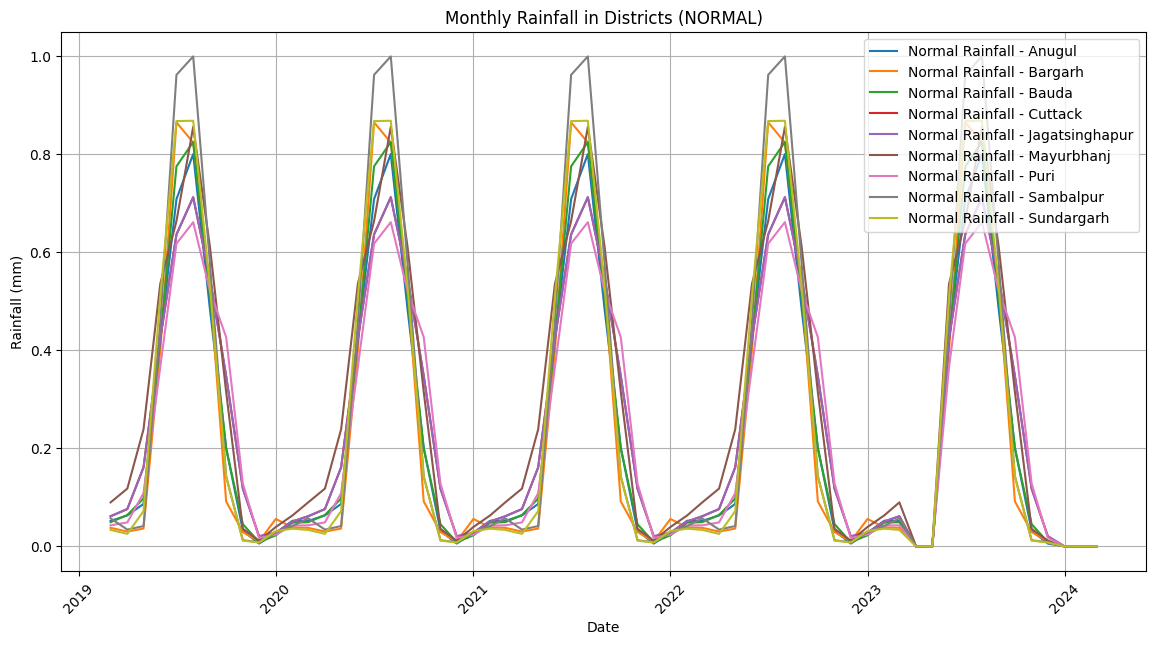

In [8]:
data.visualize_NORMAL()

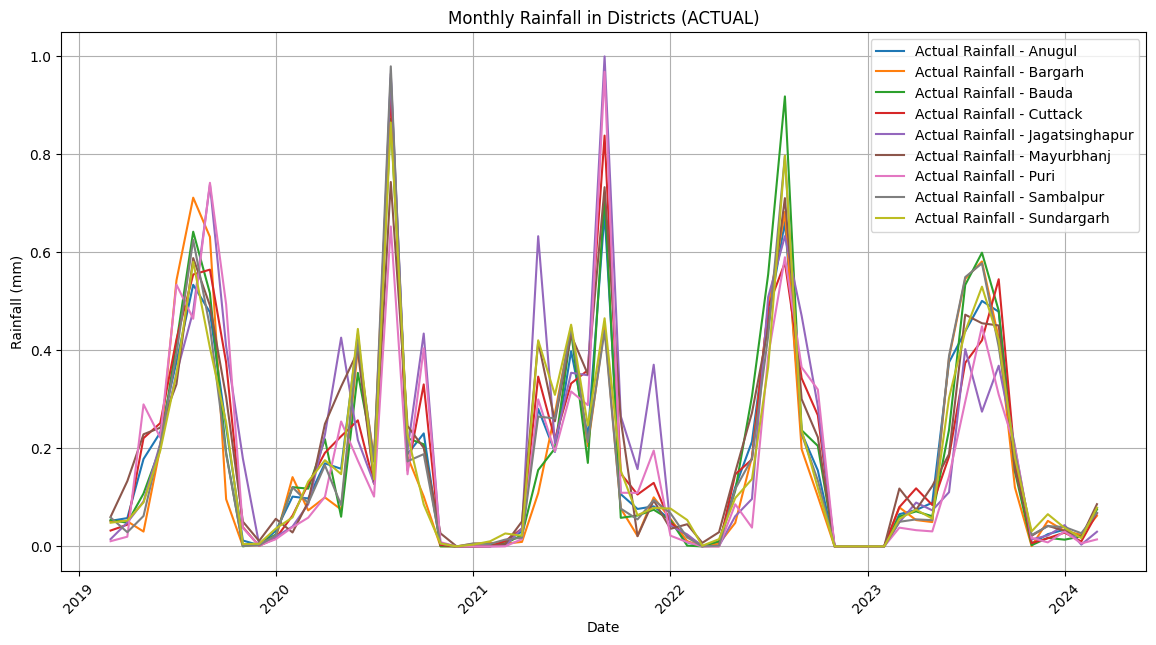

In [9]:
data.visualize_ACTUAL()

In [14]:
data.prepare_lstm_data(seq_length=3)

Shape of X: (546, 3, 4)
Shape of y: (546,)


In [15]:
data.build_lstm_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 50)             11000     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 32501 (126.96 KB)
Trainable params: 32501 (126.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
436/436 [==============================] - 5s 5ms/step - loss: 0.0369 - val_loss: 0.0267
Epoch 2/50
436/436 [==============================] - 1s 3ms/step - loss: 0.0216 - val_loss: 0.0161
Epoch 3/50
436/436 [==============================] - 1s 3ms/step - loss: 0.0177 - val_loss: 0.0144
Epoch 4/50
436/436 [==============================] - 1s 3ms/step - loss: 0.0170 - val_loss: 0.0179
Epoch 5/50
436/436 [==============================] - 1s 3ms/step - loss: 0.0169 - val_loss: 0.0157
Epoch 6/50
436/436 [==============================] - 1s 3ms/step - loss: 0.0158 - val_loss: 0.0179
Epoch 7/50
436/436 [==============================] - 1s 3ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 8/50
436/436 [==============================] - 1s 3ms/step - loss: 0.0153 - val_loss: 0.0155
Epoch 9/50
436/436 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 0.0136
Epoch 10/50
436/436 [==============================] - 1s 3ms/step - loss: 0.0147 - val_loss: 0.0168

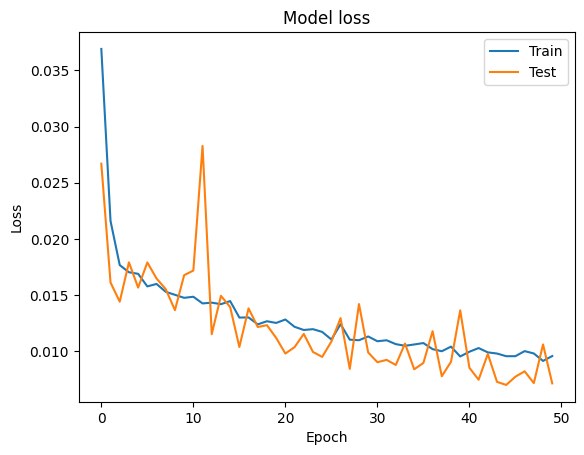

In [16]:
data.train_lstm_model(epochs=50, batch_size=1)

4/4 [==============================] - 1s 3ms/step
Root Mean Squared Error: 0.0843863705707488


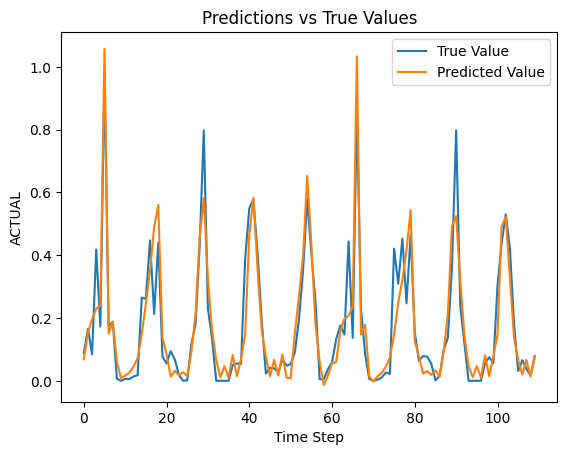

In [17]:
data.evaluate_lstm_model()